In [216]:
from abtem import *
from ase import Atoms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 

# Relative atomic contrast

Calculates the relative atomic STEM contrast and fits a power law.

In [253]:
def atomic_potential(Z):
    atoms = Atoms([Z], positions=[(2.5,2.5,2.5)], cell=(5,5,5))
    return Potential(atoms, sampling=.02, slice_thickness=1, parametrization='kirkland', projection='finite')

def powerlaw(x, amplitude, power):
    return amplitude * (x ** power)

def fit_power_law(xdata, ydata):
    logxdata = np.log10(xdata)
    logydata = weights = np.log10(ydata)

    fitfunc = lambda p, x: p[0] + p[1] * x   
    errfunc = lambda p, x, y, weights: (y - fitfunc(p, x)) / weights

    pinit = [1.0, 2.0]
    result = optimize.leastsq(errfunc, pinit, args=(logxdata, logydata, weights))

    amplitude = 10. ** result[0][0]
    power = result[0][1]
    
    return amplitude, power

In [254]:
probe = Probe(energy=300e3, semiangle_cutoff=30)

detector = AnnularDetector(45, 200)

In [255]:
Zs = np.arange(1, 90, 1, dtype=np.int)

intensities = []

for Z in tqdm(Zs):
    potential = atomic_potential(Z)

    position = (potential.extent[0] / 2, potential.extent[1] / 2)

    exit_wave = probe.multislice(position, potential, pbar=False)
    
    intensities.append(detector.detect(exit_wave)[0])
    
intensities = np.array(intensities)

best fitting powerlaw: 0.000060 * Z ** 1.721703


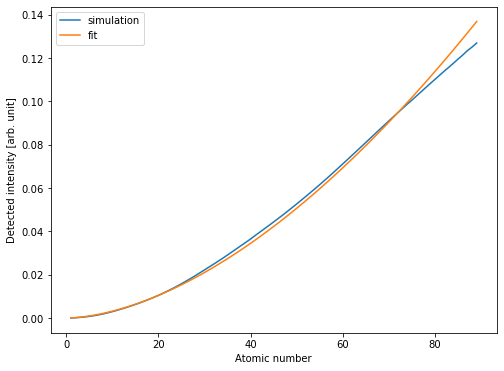

In [256]:
amplitude, power = fit_power_law(Zs, intensities)

print(f'best fitting powerlaw: {amplitude:.6f} * Z ** {power:.6f}')

plt.figure(figsize=(8,6))
plt.plot(Zs, intensities, label='simulation')
plt.plot(Zs, powerlaw(Zs, amplitude, power), label='fit')
plt.xlabel('Atomic number')
plt.ylabel('Detected intensity [arb. unit]')
plt.legend();